In [81]:
from LanguageModels.BERT import BERT
from LanguageModels.Word2Vec import Word2Vec
from Preprocessing.DataLoader import DataLoader
from Preprocessing.LemmatizerPreprocessor import LemmatizerPreprocessor
import torch
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


In [6]:
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available() # will turn off cuda if the machine doesnt have a GPU

In [2]:
lp = LemmatizerPreprocessor()

In [3]:
# Load data
data = DataLoader('../data/EMNLP2020.csv').load()

In [7]:
## Bert
bert = BERT(cuda = is_cuda)

## W2V
w2v = Word2Vec(path='../data/glove.6B/glove.6B.200d.txt') 

# Multiclass using class descriptions

In [8]:
X_multiclass_bert, y_multiclass_bert = bert.featurize(data, lp, mode='multiclass', remove_neg_samples=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1450/1450 [01:33<00:00, 15.50it/s]


In [10]:
X_multiclass_bert.shape
y_multiclass_bert.shape

(750, 1)

In [28]:
class_descriptions = [
    'Syntax, Phonology, Morphology and Word Segmentation, Linguistic Theories, Cognitive Modeling and Psycholinguistics, Discourse and Pragmatics',
    'Generation & Summarization & Machine Translation and Multilinguality' ,
    'Sentiment Analysis, Stylistic Analysis, and Argument Mining',
    'Machine Learning for NLP and Interpretability and Analysis of Models for NLP',
    'Dialogue, Speech and Interactive Systems + Question Answering',
    'NLP Applications, Language Grounding to Vision, Robotics and Beyond',
    'Computational Social Science and Social Media',
    'Information Extraction & Information Retrieval and Text Mining',
    'Speech and Multimodality',
    'Resources and Evaluation',
]

In [22]:
class_features = []
for i, desc in enumerate(class_descriptions):
    desc_clean = lp.clean(desc)
    class_features.append(bert.convert(desc_clean, method='average'))

class_features = np.array(class_features)
class_features.shape

(10, 768)

In [26]:
# find closest class

y_pred = []
for i, x in enumerate(X_multiclass_bert):
    closest_class = None
    best_dist = np.inf
    
    for j, clas in enumerate(class_features):
        dist = np.linalg.norm(x - clas)
        
        if dist < best_dist:
            best_dist = dist
            closest_class = j + 1
            
    y_pred.append(closest_class)
    
y_pred = np.array(y_pred)
y_pred.shape

(750,)

In [27]:
print("Accuracy: ", accuracy_score(y_multiclass_bert, y_pred))

Accuracy:  0.2773333333333333


# Binary classification with threshold classification

In [32]:
X_multiclass_bert, y_multiclass_bert = bert.featurize(data, lp, mode='binary', remove_neg_samples=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1450/1450 [02:58<00:00,  8.11it/s]


In [42]:
# generate one centroid to use for classification

centroid = class_features.mean(axis=0)
centroid.shape

(768,)

In [56]:
X_multiclass_bert_vis = np.vstack((X_multiclass_bert, centroid))
y_multiclass_bert_vis = np.vstack((y_multiclass_bert, 2))

In [57]:
# reduce to 2 dimensions
X_embedded2d = umap.UMAP(n_components=2).fit_transform(X_multiclass_bert_vis)

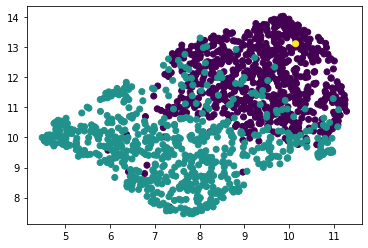

In [63]:
# visualize the space
plt.scatter(X_embedded2d[:,0], X_embedded2d[:,1], c=y_multiclass_bert_vis)

In [68]:
dists = []
for x in X_multiclass_bert:
    dists.append(np.linalg.norm(x - centroid))
dists = np.array(dists)

In [78]:
y_pred = []

for dist in dists:
    if dist < dists.mean():
        y_pred.append(0)
    else:
        y_pred.append(1)
y_pred = np.array(y_pred)

In [79]:
print("Accuracy: ", accuracy_score(y_multiclass_bert, y_pred))

Accuracy:  0.7462068965517241


## Tuning the threshold value

In [83]:
best_acc = -np.inf
best_threshold = None

for threshold in tqdm(np.linspace(min(dists), max(dists), 10000)):
    y_pred = []

    for dist in dists:
        if dist < threshold:
            y_pred.append(0)
        else:
            y_pred.append(1)
    y_pred = np.array(y_pred)
    
    acc = accuracy_score(y_multiclass_bert, y_pred)
    
    if (acc > best_acc):
        best_acc = acc
        best_threshold = threshold
    

  0%|          | 0/10000 [00:00<?, ?it/s]

In [86]:
print('Best accuracy:', best_acc, 'Best threshold:', best_threshold)

Best accuracy: 0.7489655172413793 Best threshold: 6.372888352277458
